In [1]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
with open('stop.txt') as f:
    stopwords = f.read().replace('\n',' ').split()

In [3]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')

stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
with open('sentences.txt', encoding='utf-8') as f:
    text = f.read().replace('\n',' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    print(text)
    text = ''.join([t for t in text if t not in list('0123456789')])
    text = text.lower().split()

text = [w for w in text if w not in stopwords][:2000]
# text

In recent years the field of data science has rapidly evolved driven by advancements in artificial intelligence AI and machine learning As industries increasingly rely on datadriven insights to make strategic decisions the demand for skilled professionals in this domain has surged Educational institutions are adapting their curricula to equip students with the knowledge and skills needed for these roles focusing on statistical analysis programming and AI technologies The job market is witnessing a growing number of opportunities in data science as companies across various sectors seek experts to harness big data and AI for competitive advantage This trend highlights the importance of staying current with technological advancements and continuously updating ones skill set to thrive in this dynamic field  


In [5]:
temp = sorted(text)
len(temp)

78

In [6]:
#used skip gram technique to create the dataset

wind_size = 3
num_neg_sample = 2

data = []
for idx, center_word in enumerate(text[wind_size-1:-wind_size +1]):
    context_words = [context_word for context_word in text[idx:idx+2*wind_size-1] if context_word != center_word]
    
    for context_word in context_words:
        data.append([center_word, context_word, 1])

        neg_samples = np.random.choice([word for word in text[wind_size - 1: -wind_size + 1] if word != center_word and word not in context_words], num_neg_sample)
        for neg_samp in neg_samples:
            data.append([center_word, neg_samp, 0])
# data

In [7]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'],data=data)
words = np.intersect1d(df.context_word, df.center_word)
print(words)
df = df[df.context_word.isin(words) & df.center_word.isin(words)].reset_index(drop=True)
df.head(10)

['across' 'adapting' 'advancements' 'advantage' 'ai' 'analysis'
 'artificial' 'big' 'companies' 'competitive' 'continuously' 'current'
 'curricula' 'data' 'datadriven' 'decisions' 'demand' 'domain' 'driven'
 'educational' 'equip' 'evolved' 'experts' 'field' 'focusing' 'growing'
 'harness' 'highlights' 'importance' 'increasingly' 'industries'
 'insights' 'institutions' 'intelligence' 'job' 'knowledge' 'learning'
 'machine' 'make' 'market' 'needed' 'number' 'ones' 'opportunities'
 'professionals' 'programming' 'rapidly' 'rely' 'roles' 'science'
 'sectors' 'seek' 'set' 'skill' 'skilled' 'skills' 'statistical' 'staying'
 'strategic' 'students' 'surged' 'technological' 'technologies' 'thrive'
 'trend' 'updating' 'various' 'witnessing']


,center_word,context_word,label
0,field,adapting,0
1,field,ones,0
2,field,skilled,0
3,field,skills,0
4,field,data,1
5,field,ai,0
6,field,decisions,0
7,field,science,1
8,field,surged,0
9,field,ai,0


In [8]:
def sigmoid(x, scale=1):
    return 1 / (1 + np.exp(-x*scale))

In [9]:
def normalise_data(data):
    row_norms = np.sqrt((data.values ** 2).sum(axis = 1)).reshape(-1, 1)
    return data.divide(row_norms, axis = 1)

In [10]:
def train(df, main_embeddings, context_embeddings, lr):
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_outside = context_embeddings.loc[df.context_word].values
    # print(main_embeddings_center)
    diffs = main_embeddings_center - context_embeddings_outside

    dot_prod = np.sum(main_embeddings_center * context_embeddings_outside, axis=1)
    scores = sigmoid(dot_prod)
    errors = (df.label - scores).values.reshape(-1, 1)

    updates = diffs * errors * lr
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    # print(updates_df_center)

    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]

    main_embeddings = normalise_data(main_embeddings)
    context_embeddings = normalise_data(context_embeddings)

    # print(main_embeddings)
    return main_embeddings, context_embeddings

In [11]:
embed_size = 15

main_embeddings = np.random.normal(0, 0.1, (len(words), embed_size))
row_norms = np.sqrt((main_embeddings ** 2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0, 0.1, (len(words), embed_size))
row_norms = np.sqrt((context_embeddings ** 2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)
# print(main_embeddings)
for _ in range(25):
    main_embeddings, context_embeddings = train(df, main_embeddings, context_embeddings, 0.1)

In [12]:
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'king'], key=lambda t: -t[2])[:10]

[]

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
trans_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

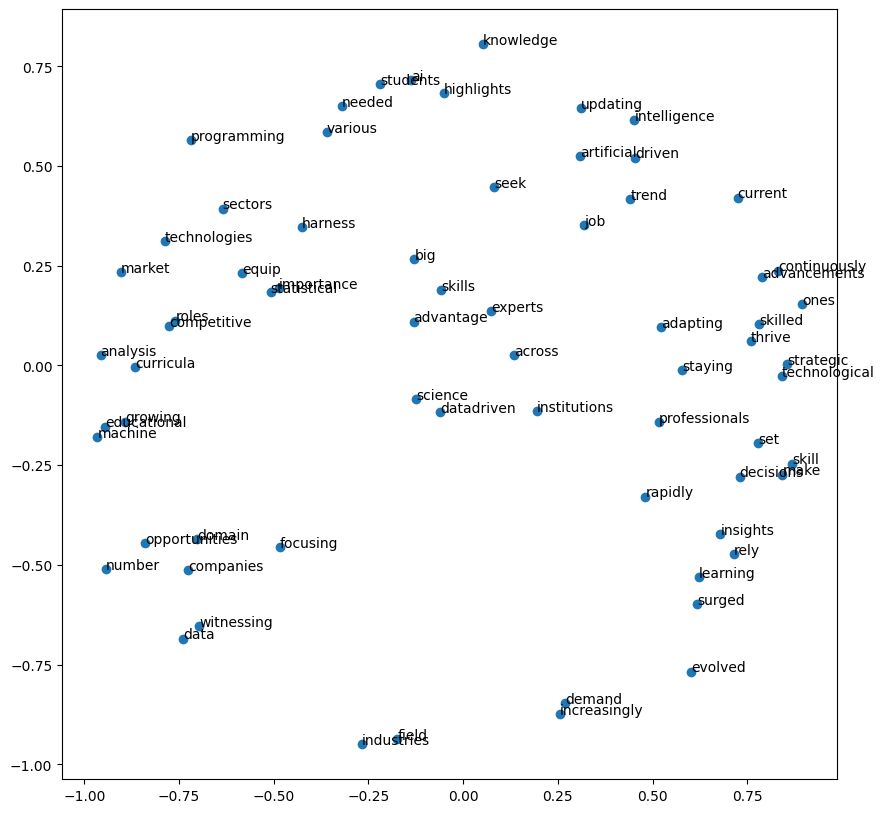

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(trans_embeddings[:,0], trans_embeddings[:,1])
for idx,row in enumerate(trans_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
# plt.axvline(0, color='k', linestyle='--', alpha=0.5)
# plt.axhline(0, color='k', linestyle='--', alpha=0.5)

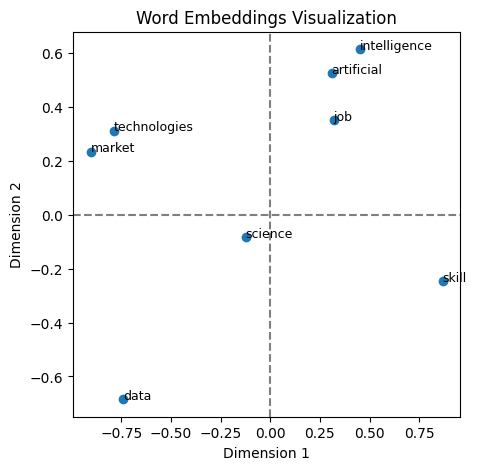

In [15]:
custom_words_used = ['data', 'science', 'market', 'job', 'artificial', 'intelligence', 'skill', 'technologies']

word_to_idx = {word: idx for idx, word in enumerate(words_used)}

filtered_indices = [word_to_idx[word] for word in custom_words_used if word in word_to_idx]

filtered_embeddings = trans_embeddings[filtered_indices]
filtered_words = [word for word in custom_words_used if word in word_to_idx]

# Plotting
plt.figure(figsize=(5, 5))
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1])
for idx, row in enumerate(filtered_embeddings):
    plt.text(row[0], row[1], str(filtered_words[idx]), fontsize=9)
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embeddings Visualization')
plt.show()